## Introduction

The SPDR S&P 500 ETF Trust (SPY) is an exchange-traded fund that aims to provide investment results that correspond generally to the price and yield performance of the S&P 500 Index. It is designed to track the S&P 500, a market-capitalization-weighted index of 500 leading publicly traded companies in the U.S. across various industries. SPY is one of the most widely recognized ETFs and is used by investors for exposure to U.S. equities.

Our task is to predict the closing prices of SPY using the data from Yahoo Finance.

In [320]:
# import libraries
import pandas as pd
import numpy as np
import yfinance as yf
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import mplfinance as mpf
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn import metrics
from sklearn.model_selection import KFold
import itertools

# ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [321]:
# remove scientific notation
pd.set_option('display.float_format', lambda x: '%.3f' % x)

### Get the data

In [322]:
# download data
df = yf.download('SPY')
df

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1993-01-29,43.969,43.969,43.750,43.938,24.841,1003200
1993-02-01,43.969,44.250,43.969,44.250,25.017,480500
1993-02-02,44.219,44.375,44.125,44.344,25.070,201300
1993-02-03,44.406,44.844,44.375,44.812,25.335,529400
1993-02-04,44.969,45.094,44.469,45.000,25.441,531500
...,...,...,...,...,...,...
2024-03-04,512.030,514.200,512.000,512.300,512.300,49799300
2024-03-05,510.240,510.700,504.910,507.180,507.180,72855600
2024-03-06,510.550,512.070,508.420,509.750,509.750,68382400


### Feature engineering

In [323]:
# check for missing values
df.isna().sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

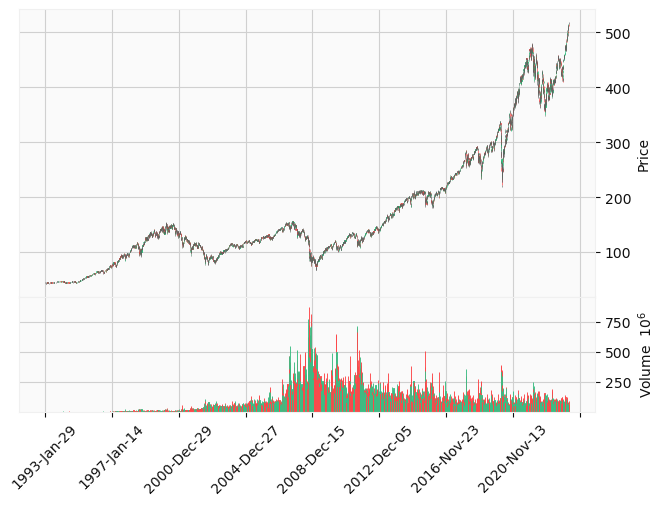

In [324]:
# plot the data
mpf.plot(df,type='candle',volume=True, style='yahoo')


In [325]:
df.columns

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')

In [326]:
# feature engineering
# calculate the moving average
df['MA50'] = df['Close'].rolling(50).mean()
df['MA200'] = df['Close'].rolling(200).mean()
# calculate the RSI
delta = df['Close'].diff()
gain = (delta.where(delta > 0, 0)).rolling(14).mean()
loss = (-delta.where(delta < 0, 0)).rolling(14).mean()
rs = gain / loss
df['RSI'] = 100 - (100 / (1 + rs))
# drop missing values
df = df.dropna()
# print the first 5 rows
df.head()

,Open,High,Low,Close,Adj Close,Volume,MA50,MA200,RSI
Date,,,,,,,,,
1993-11-11,46.500,46.625,46.344,46.375,26.695,88900,46.269,45.206,50.000
1993-11-12,46.469,46.750,46.438,46.594,26.820,108200,46.274,45.219,51.765
1993-11-15,46.688,46.688,46.438,46.562,26.802,243300,46.278,45.231,51.765
1993-11-16,46.656,46.812,46.469,46.781,26.928,492600,46.292,45.243,54.945
1993-11-17,46.812,46.812,46.406,46.531,26.785,39600,46.305,45.252,44.318


In [327]:
# calculate the high low percentage
df['HL_pct'] = (df['High'] - df['Low']) / df['Close'] * 100.0
# calculate the percentage change
df['PCT_change'] = (df['Close'] - df['Open']) / df['Open'] * 100.0



In [328]:
# Difference in 'Close' prices from the previous day
df['Close_diff'] = df['Close'].diff(1)

# Previous day's 'Close' price
df['Close_lag'] = df['Close'].shift(1)

# Log of 'Close' prices
df['ln_Close'] = np.log(df['Close'])

# Difference in log of 'Close' prices from the previous day
df['dln_Close'] = df['ln_Close'].diff(1)

# Previous day's log of 'Close' prices
df['ln_Close_lag'] = df['ln_Close'].shift(1)

# Difference in previous day's log of 'Close' prices
df['dln_Close_lag'] = df['dln_Close'].shift(1)

# Difference in 'Volume' from the previous day
df['Volume_diff'] = df['Volume'].diff(1)

# Log of 'Volume'
df['ln_Volume'] = np.log(df['Volume'])

# Difference in log of 'Volume' from the previous day
df['dln_Volume'] = df['ln_Volume'].diff(1)

# Creating a trend variable
df['trend'] = np.arange(1, len(df) + 1)

# Display the first few rows to verify the new columns
print(df.head())

             Open   High    Low  Close  Adj Close  Volume   MA50  MA200  \
Date                                                                      
1993-11-11 46.500 46.625 46.344 46.375     26.695   88900 46.269 45.206   
1993-11-12 46.469 46.750 46.438 46.594     26.820  108200 46.274 45.219   
1993-11-15 46.688 46.688 46.438 46.562     26.802  243300 46.278 45.231   
1993-11-16 46.656 46.812 46.469 46.781     26.928  492600 46.292 45.243   
1993-11-17 46.812 46.812 46.406 46.531     26.785   39600 46.305 45.252   

              RSI  HL_pct  ...  Close_diff  Close_lag  ln_Close  dln_Close  \
Date                       ...                                               
1993-11-11 50.000   0.606  ...         NaN        NaN     3.837        NaN   
1993-11-12 51.765   0.671  ...       0.219     46.375     3.841      0.005   
1993-11-15 51.765   0.537  ...      -0.031     46.594     3.841     -0.001   
1993-11-16 54.945   0.735  ...       0.219     46.562     3.845      0.005   
1993-1

### Modeling and prediction

We are going to build a couple different models
- Simple linear regression
- LASSO
- ARIMA
- VAR
- Random Forest

In [329]:
# drop missing values
df = df.dropna()
# print the first 5 rows
df.head()

,Open,High,Low,Close,Adj Close,Volume,MA50,MA200,RSI,HL_pct,...,Close_diff,Close_lag,ln_Close,dln_Close,ln_Close_lag,dln_Close_lag,Volume_diff,ln_Volume,dln_Volume,trend
Date,,,,,,,,,,,,,,,,,,,,,
1993-11-15,46.688,46.688,46.438,46.562,26.802,243300,46.278,45.231,51.765,0.537,...,-0.031,46.594,3.841,-0.001,3.841,0.005,135100.000,12.402,0.810,3
1993-11-16,46.656,46.812,46.469,46.781,26.928,492600,46.292,45.243,54.945,0.735,...,0.219,46.562,3.845,0.005,3.841,-0.001,249300.000,13.107,0.705,4
1993-11-17,46.812,46.812,46.406,46.531,26.785,39600,46.305,45.252,44.318,0.873,...,-0.250,46.781,3.840,-0.005,3.845,0.005,-453000.000,10.587,-2.521,5
1993-11-18,46.469,46.562,46.281,46.406,26.713,240800,46.313,45.259,42.391,0.606,...,-0.125,46.531,3.837,-0.003,3.840,-0.005,201200.000,12.392,1.805,6
1993-11-19,46.250,46.375,46.219,46.312,26.659,106000,46.311,45.265,38.462,0.337,...,-0.094,46.406,3.835,-0.002,3.837,-0.003,-134800.000,11.571,-0.821,7


In [330]:
# split holdout set and work set, holdout set is 252 trading days, approximately 0.5 year, the rest is work set
holdout = df.iloc[-20:]
work = df.iloc[-504:-20]

In [331]:
work.columns

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'MA50', 'MA200',
       'RSI', 'HL_pct', 'PCT_change', 'Close_diff', 'Close_lag', 'ln_Close',
       'dln_Close', 'ln_Close_lag', 'dln_Close_lag', 'Volume_diff',
       'ln_Volume', 'dln_Volume', 'trend'],
      dtype='object')

### Model 1: Linear

In [332]:
# model 1: linear regression

# create a linear regression model using only the moving averages, RSI, high low percentage, and percentage change, log of 'Close' prices, and log of 'Volume'
model1 = LinearRegression()
# define the features
features = ['MA50', 'MA200', 'RSI', 'HL_pct', 'PCT_change', 'ln_Close', 'dln_Close', 'ln_Close_lag', 'dln_Close_lag', 'Volume_diff', 'ln_Volume', 'dln_Volume']
# define the target
target = 'Close'
# set the features and target
X = work[features]
y = work[target]

# cross-validation setup
k = KFold(n_splits=4, shuffle=False)

# cross validated rmse for each fold
rmse = []
for train_index, test_index in k.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    model1.fit(X_train, y_train)
    y_pred = model1.predict(X_test)
    rmse.append(np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

# show the results in a dataframe
rmse_df = pd.DataFrame(rmse, columns=['RMSE'])
print(rmse_df)
# calculate rmse on the holdout set
X_holdout = holdout[features]
y_holdout = holdout[target]
y_pred_holdout = model1.predict(X_holdout)
rmse_holdout = np.sqrt(metrics.mean_squared_error(y_holdout, y_pred_holdout))
print('RMSE on holdout set:', rmse_holdout)

# predict next 20 closing prices and put them in a list
y_pred = model1.predict(X_holdout)
y_pred

# the dates
start_date = '2024-02-12'
dates = pd.date_range(start_date, periods=20, freq='B')

# put the dates and the predicted closing prices in a dataframe
last_df = pd.DataFrame({'Date': dates, 'Close': y_pred})
last_df

# new dates
new_dates = pd.date_range('2024-03-11', periods=20, freq='B')


   RMSE
0 2.916
1 2.237
2 0.890
3 2.706
RMSE on holdout set: 8.307611978813018


Let's build a bit simplified mode, because to predict future y, we need to get future X. We need to do a lot of extrapolation which could be naive approach to get good results

In [333]:

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error


# Simplify features to just MA50 and MA200 for this example
simplified_features = ['MA50', 'MA200']
X_simplified = df[simplified_features]
y = df[target]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_simplified, y, test_size=0.2, random_state=42)

# Initialize and train the simplified model
simplified_model = LinearRegression()
simplified_model.fit(X_train, y_train)

# Make predictions on the test set
predictions = simplified_model.predict(X_test)

# Calculate the rmse for the predictions
rmse_1 = np.sqrt(mean_squared_error(y_test, predictions))
print('RMSE:', rmse_1)

# Calculate the rate of change for MA50 and MA200 over the last 5 days
ma50_change_rate = (df['MA50'].iloc[-1] - df['MA50'].iloc[-6]) / 5
ma200_change_rate = (df['MA200'].iloc[-1] - df['MA200'].iloc[-6]) / 5

# Project these rates forward for the next 20 days
projected_ma50 = [df['MA50'].iloc[-1] + (i + 1) * ma50_change_rate for i in range(20)]
projected_ma200 = [df['MA200'].iloc[-1] + (i + 1) * ma200_change_rate for i in range(20)]

# Use these projected values as your future features
future_features = np.column_stack((projected_ma50, projected_ma200))

# Predict the next 20 days using the simplified model and these projected future feature values
future_predictions = simplified_model.predict(future_features)

# Creating the DataFrame with the dates and predicted closing prices
predictions_df = pd.DataFrame({
    'Date': new_dates,
    'Predicted_Close': future_predictions
})

predictions_df



RMSE: 8.050146358979758


,Date,Predicted_Close
0,2024-03-11,500.985
1,2024-03-12,501.804
2,2024-03-13,502.623
3,2024-03-14,503.442
4,2024-03-15,504.261
5,2024-03-18,505.080
6,2024-03-19,505.899
7,2024-03-20,506.718
8,2024-03-21,507.537
9,2024-03-22,508.356


### Model 2: Polynomial

In [334]:
# predictions

simplified_features = ['MA50', 'MA200']
X_simplified = df[simplified_features]
y = df[target]

# Transform your features into polynomial features of degree 2
poly = PolynomialFeatures(degree=2)
X_poly = poly.fit_transform(X_simplified)

# Split the polynomial features into training and testing sets
X_train_poly, X_test_poly, y_train, y_test = train_test_split(X_poly, y, test_size=0.2, random_state=42)

# Initialize and train the model on polynomial features
poly_model = LinearRegression()
poly_model.fit(X_train_poly, y_train)

# Make predictions on the test set using polynomial features
predictions_poly = poly_model.predict(X_test_poly)

# Calculate the RMSE for the polynomial predictions
rmse_poly = np.sqrt(mean_squared_error(y_test, predictions_poly))
print('RMSE (Polynomial Degree 2):', rmse_poly)

# Use these projected values as your future features (poly transformation needed)
projected_ma50 = [df['MA50'].iloc[-1] + (i + 1) * ma50_change_rate for i in range(20)]
projected_ma200 = [df['MA200'].iloc[-1] + (i + 1) * ma200_change_rate for i in range(20)]
future_features_projected = np.column_stack((projected_ma50, projected_ma200))

# Transform future features into polynomial features
future_features_poly = poly.transform(future_features_projected)

# Predict the next 20 days using the polynomial model and these projected future feature values
future_predictions_poly = poly_model.predict(future_features_poly)

# Creating the DataFrame with the dates and predicted closing prices
predictions_poly_df = pd.DataFrame({
    'Date': new_dates,
    'Predicted_Close': future_predictions_poly
})

predictions_poly_df


RMSE (Polynomial Degree 2): 7.982891773264705


,Date,Predicted_Close
0,2024-03-11,503.122
1,2024-03-12,504.029
2,2024-03-13,504.937
3,2024-03-14,505.846
4,2024-03-15,506.755
5,2024-03-18,507.665
6,2024-03-19,508.576
7,2024-03-20,509.488
8,2024-03-21,510.400
9,2024-03-22,511.313


### Model 3: LASSO

In [335]:
from sklearn.linear_model import Lasso
# For simplicity, this example uses the original features without polynomial transformation
# Initialize the Lasso model
lasso_model = Lasso()

# Now you can fit the model
lasso_model.fit(X_train, y_train)

# Prepare the future features for prediction
future_features_projected = np.column_stack((projected_ma50, projected_ma200))

# Predict the next 20 days using the Lasso model
future_predictions_lasso = lasso_model.predict(future_features_projected)

# Creating the DataFrame with the dates and predicted closing prices
predictions_lasso_df = pd.DataFrame({
    'Date': new_dates,
    'Predicted_Close': future_predictions_lasso
})

# calculate RMSE on the holdout set
X_holdout = holdout[simplified_features]
y_holdout = holdout[target]
y_pred_holdout = lasso_model.predict(X_holdout)
rmse_lasso = np.sqrt(metrics.mean_squared_error(y_holdout, y_pred_holdout))
print('RMSE on holdout set:', rmse_lasso)

predictions_lasso_df

RMSE on holdout set: 13.743283408840968


,Date,Predicted_Close
0,2024-03-11,500.516
1,2024-03-12,501.330
2,2024-03-13,502.143
3,2024-03-14,502.957
4,2024-03-15,503.770
5,2024-03-18,504.584
6,2024-03-19,505.397
7,2024-03-20,506.211
8,2024-03-21,507.024
9,2024-03-22,507.838


### Model 4: ARIMA

In [336]:
# model 4: ARIMA
from statsmodels.tsa.arima.model import ARIMA

# create an ARIMA model
model4 = ARIMA(work['Close'], order=(2,2,2))
model_fit = model4.fit()

# predict on the holdout set
forecast = model_fit.forecast(steps=len(holdout))

# calculate RMSE
rmse_ARIMA = np.sqrt(mean_squared_error(holdout['Close'], forecast))
print('RMSE on holdout set:', rmse_ARIMA)

# predict 20 closing prices for holdout set
y_pred = model_fit.forecast(steps=20)

# dataframe
pd.DataFrame({'Date': dates, 'Close': y_pred})


RMSE on holdout set: 6.779839597920309


,Date,Close
484,2024-02-12,499.265
485,2024-02-13,498.680
486,2024-02-14,499.580
487,2024-02-15,499.046
488,2024-02-16,499.897
489,2024-02-19,499.411
490,2024-02-20,500.216
491,2024-02-21,499.775
492,2024-02-22,500.536
493,2024-02-23,500.137


In [337]:
# Grid search for best ARIMA parameters based on AIC
p = d = q = range(0, 3)
pdq = list(itertools.product(p, d, q))
lowest_aic = np.inf
best_pdq = None


for param in pdq:
    try:
        model_temp = ARIMA(df['Close'], order=param)
        results_temp = model_temp.fit()
        
        if results_temp.aic < lowest_aic:
            lowest_aic = results_temp.aic
            best_pdq = param
    except:
        continue

print(f'Best ARIMA{best_pdq} model AIC: {lowest_aic}')

# Fit the best model
model_best = ARIMA(df['Close'], order=best_pdq)
model_fit_best = model_best.fit()

# Forecast with the best model
forecast_best = model_fit_best.forecast(steps=20)

# dataframe for new dates and predicted closing prices
arima_df = pd.DataFrame({'Date': new_dates, 'Close': forecast_best})
arima_df

Best ARIMA(2, 2, 2) model AIC: 34318.9966057711


,Date,Close
7632,2024-03-11,512.040
7633,2024-03-12,512.285
7634,2024-03-13,512.278
7635,2024-03-14,512.531
7636,2024-03-15,512.547
7637,2024-03-18,512.776
7638,2024-03-19,512.815
7639,2024-03-20,513.023
7640,2024-03-21,513.080
7641,2024-03-22,513.272


### Model 5: VAR

In [338]:
# model 5: VAR
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller

# create a VAR model
model5 = VAR(work[['Close', 'Volume']])
model_fit = model5.fit()

# predict on the holdout set
forecast = model_fit.forecast(model_fit.endog, steps=len(holdout))

# calculate RMSE
rmse_VAR = np.sqrt(mean_squared_error(holdout['Close'], forecast[:,0]))
print('RMSE on holdout set:', rmse_VAR)

# predict next 20 closing prices and put them in a list
y_pred = model_fit.forecast(model_fit.endog, steps=20)

# dataframe
pd.DataFrame({'Date': dates, 'Close': y_pred[:,0]})

RMSE on holdout set: 12.011894092007958


,Date,Close
0,2024-02-12,498.021
1,2024-02-13,497.732
2,2024-02-14,497.449
3,2024-02-15,497.169
4,2024-02-16,496.892
5,2024-02-19,496.617
6,2024-02-20,496.344
7,2024-02-21,496.072
8,2024-02-22,495.802
9,2024-02-23,495.534


In [339]:
# model 5: VAR
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller

# create a VAR model
model5 = VAR(df[['Close', 'Volume']])
model_fit = model5.fit()

# predict on the holdout set
forecast = model_fit.forecast(model_fit.endog, steps=len(holdout))


# predict for new dates
y_pred = model_fit.forecast(model_fit.endog, steps=20)

# dataframe
pd.DataFrame({'Date': new_dates, 'Close': y_pred[:,0]})

,Date,Close
0,2024-03-11,511.885
1,2024-03-12,512.050
2,2024-03-13,512.215
3,2024-03-14,512.380
4,2024-03-15,512.545
5,2024-03-18,512.710
6,2024-03-19,512.876
7,2024-03-20,513.041
8,2024-03-21,513.206
9,2024-03-22,513.372


## Conclusion

After testing all models we got the first linear model was the best. In terms of RMSE it had the smallest value

In [340]:
# put all rmse values in a dataframe
rmse_values = [rmse_1, rmse_poly, rmse_lasso, rmse_ARIMA, rmse_VAR]
# round the values to 2 decimal places
rmse_values = [round(x, 3) for x in rmse_values] 
results = pd.DataFrame({'Model': ['Linear Regression', 'Polynomial Regression', 'LASSO', 'ARIMA', 'VAR'],
                'RMSE': rmse_values})
results

,Model,RMSE
0,Linear Regression,8.050
1,Polynomial Regression,7.983
2,LASSO,13.743
3,ARIMA,6.780
4,VAR,12.012


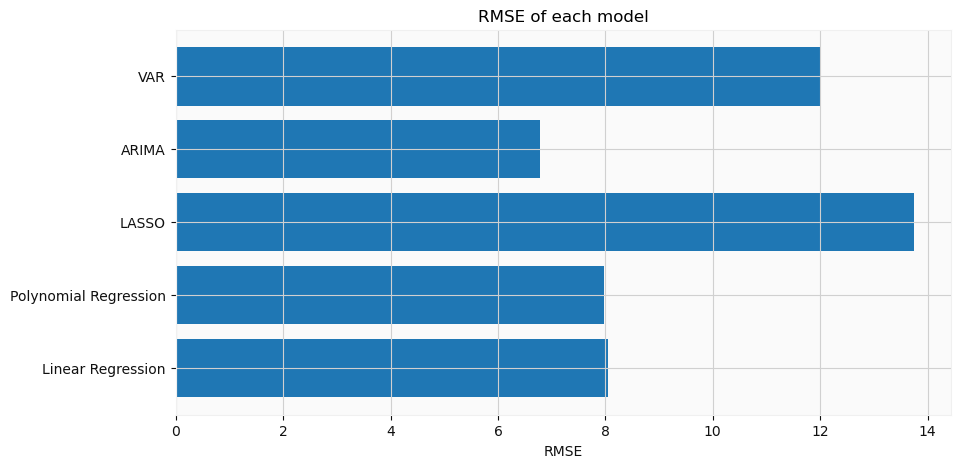

In [341]:
# plot results
plt.figure(figsize=(10, 5))
plt.barh(results['Model'], results['RMSE'])
plt.xlabel('RMSE')
plt.title('RMSE of each model')
plt.show()


In [342]:
# check the best model
arima_df

,Date,Close
7632,2024-03-11,512.040
7633,2024-03-12,512.285
7634,2024-03-13,512.278
7635,2024-03-14,512.531
7636,2024-03-15,512.547
7637,2024-03-18,512.776
7638,2024-03-19,512.815
7639,2024-03-20,513.023
7640,2024-03-21,513.080
7641,2024-03-22,513.272


## Save Forecast

In [343]:
firstname = 'artyom'
lastname = 'ashigov'
filename = f'{firstname}_{lastname}.csv'

arima_df.columns = ['date', f'{firstname}_{lastname}']

arima_df.to_csv(filename, index = 0)